In [5]:
!unzip 'dog_images_resnet.zip'

Archive:  dog_images_resnet.zip
   creating: dog_images_resnet/
  inflating: __MACOSX/._dog_images_resnet  
  inflating: dog_images_resnet/.DS_Store  
  inflating: __MACOSX/dog_images_resnet/._.DS_Store  
   creating: dog_images_resnet/store/
   creating: dog_images_resnet/store/happy/
  inflating: __MACOSX/dog_images_resnet/store/._happy  
   creating: dog_images_resnet/store/sad/
  inflating: __MACOSX/dog_images_resnet/store/._sad  
   creating: dog_images_resnet/store/angry/
  inflating: __MACOSX/dog_images_resnet/store/._angry  
   creating: dog_images_resnet/store/relaxed/
  inflating: __MACOSX/dog_images_resnet/store/._relaxed  
  inflating: dog_images_resnet/store/happy/5547551217_69bb27ca60_b.jpg  
  inflating: __MACOSX/dog_images_resnet/store/happy/._5547551217_69bb27ca60_b.jpg  
  inflating: dog_images_resnet/store/happy/16778245778_6cd880b0be_b.jpg  
  inflating: __MACOSX/dog_images_resnet/store/happy/._16778245778_6cd880b0be_b.jpg  
  inflating: dog_images_resnet/store/happ

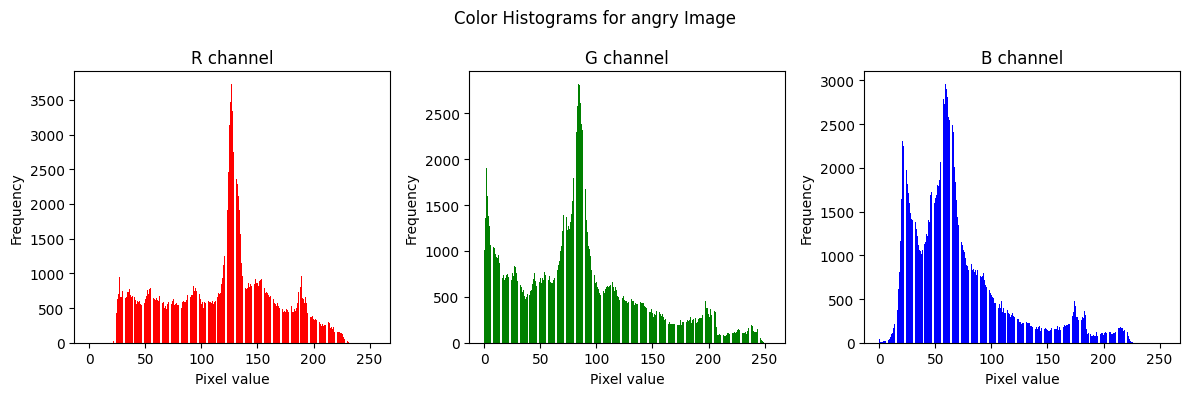

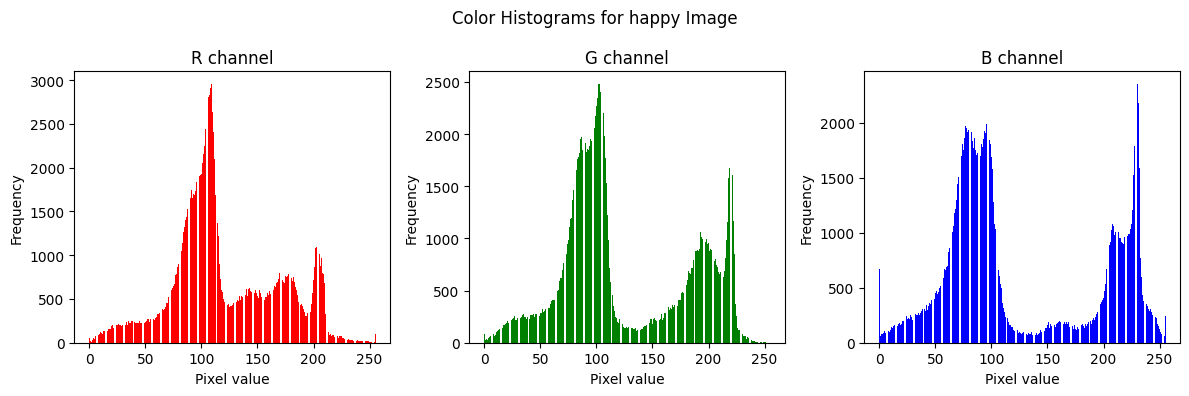

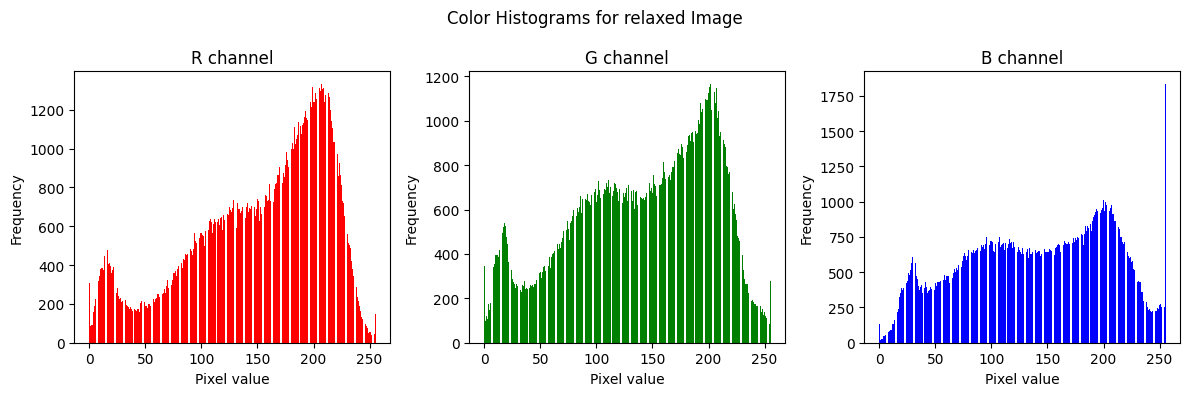

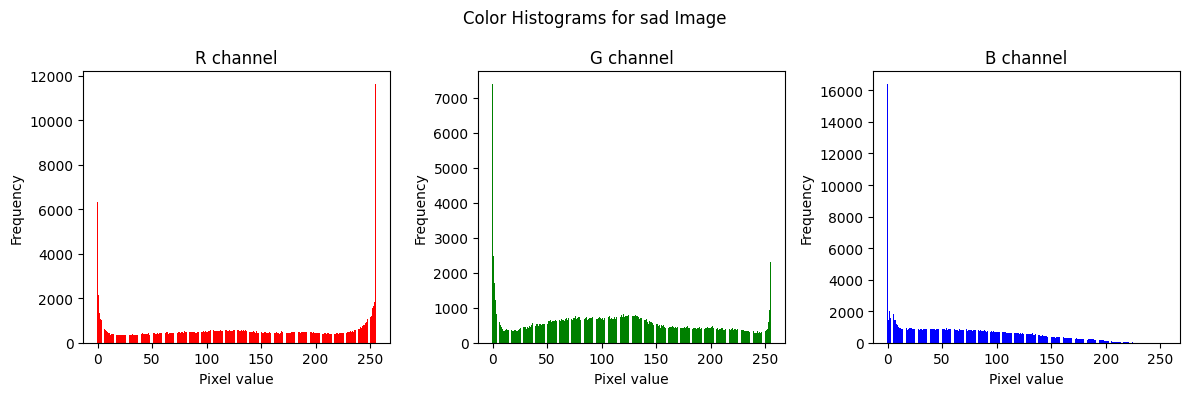

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the dataset directory
dataset_dir = 'dog_images_resnet/store'

# Define the categories and corresponding directories
categories = ['angry', 'happy', 'relaxed', 'sad']
data = []

# Function to compute color histograms
def compute_color_histogram(image, bins=256):
    histogram = {'r': [], 'g': [], 'b': []}
    for i, color in enumerate(['r', 'g', 'b']):
        hist = np.histogram(image[:, :, i], bins=bins, range=(0, 256))[0]
        histogram[color] = hist
    return histogram

# Iterate through each category to collect image size and color histogram information
for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    for file_name in os.listdir(category_dir):
        if file_name.endswith(('png', 'jpg', 'jpeg')):
            file_path = os.path.join(category_dir, file_name)
            with Image.open(file_path) as img:
                img = img.convert('RGB')
                img_np = np.array(img)
                width, height = img.size
                histogram = compute_color_histogram(img_np)
                data.append({'category': category, 'width': width, 'height': height, 'histogram': histogram})
                break  # Take only one sample image per category

# Create a DataFrame
df = pd.DataFrame(data)

# Function to plot histograms for a given image
def plot_histograms(histograms, category):
    plt.figure(figsize=(12, 4))
    plt.suptitle(f'Color Histograms for {category} Image')

    for i, color in enumerate(['r', 'g', 'b']):
        plt.subplot(1, 3, i+1)
        plt.bar(range(256), histograms[color], color=color)
        plt.title(f'{color.upper()} channel')
        plt.xlabel('Pixel value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plot histograms for one sample image per category
for category in categories:
    sample_df = df[df['category'] == category]
    if not sample_df.empty:
        row = sample_df.iloc[0]
        plot_histograms(row['histogram'], category)


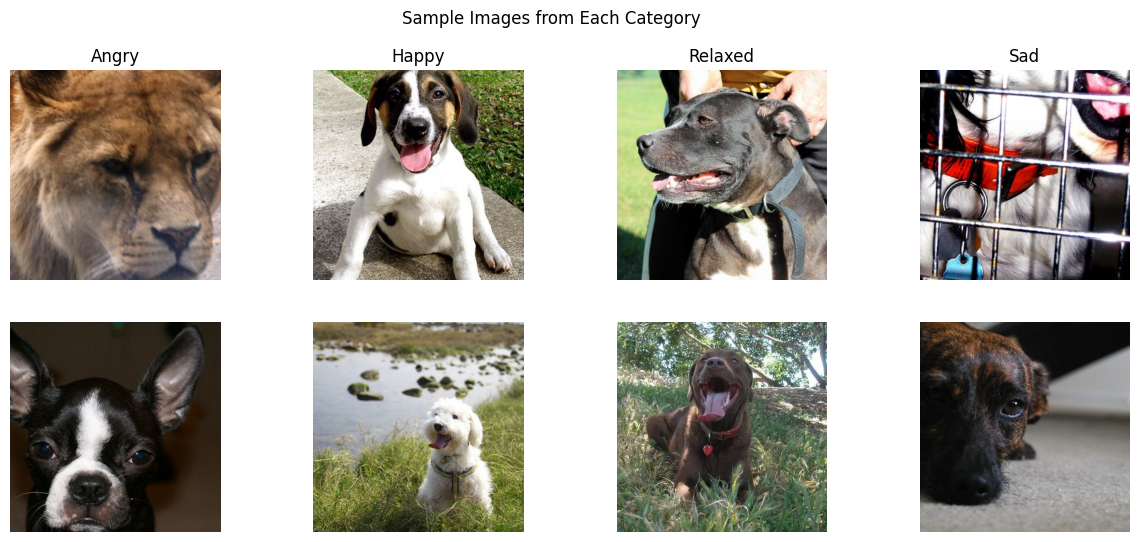

In [ ]:
# Display sample image
fig, axes = plt.subplots(2, len(categories), figsize=(15, 6))
for i, category in enumerate(categories):
    category_dir = os.path.join(dataset_dir, category)
    sample_files = [f for f in os.listdir(category_dir) if f.endswith(('png', 'jpg', 'jpeg'))][:2]
    for j, file_name in enumerate(sample_files):
        file_path = os.path.join(category_dir, file_name)
        img = Image.open(file_path)
        axes[j, i].imshow(img)
        axes[j, i].axis('off')
        if j == 0:
            axes[j, i].set_title(category.capitalize())
plt.suptitle('Sample Images from Each Category')
plt.show()

In [ ]:
# Identify outliers based on histogram data
def find_outliers(df, threshold=1.5):
    means = {color: [] for color in ['r', 'g', 'b']}
    stds = {color: [] for color in ['r', 'g', 'b']}

    for color in ['r', 'g', 'b']:
        for histogram in df['histogram']:
            means[color].append(np.mean(histogram[color]))
            stds[color].append(np.std(histogram[color]))

    mean_df = pd.DataFrame(means)
    std_df = pd.DataFrame(stds)

    outliers = df[(np.abs(mean_df - mean_df.mean()) > threshold * mean_df.std()).any(axis=1) |
                  (np.abs(std_df - std_df.mean()) > threshold * std_df.std()).any(axis=1)]
    return outliers

outliers = find_outliers(df)

# Display outliers
if not outliers.empty:
    print("Identified Outliers:")
    for idx, row in outliers.iterrows():
        print(f"Category: {row['category']}, Width: {row['width']}, Height: {row['height']}")
        plot_histograms(row['histogram'], row['category'], idx)
else:
    print("No outliers identified with the current threshold.")

No outliers identified with the current threshold.


In [26]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Image dimensions for VGG16
img_height, img_width = 224, 224

# Load and preprocess images
data = []
labels = []

for category in categories:
    category_dir = os.path.join(dataset_dir, category)
    for file_name in os.listdir(category_dir):
        if file_name.endswith(('png', 'jpg', 'jpeg')):
            file_path = os.path.join(category_dir, file_name)
            with Image.open(file_path) as img:
                img = img.resize((img_width, img_height))
                img_array = np.array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(category)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)

# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

val_datagen = ImageDataGenerator()

# Prepare the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add custom layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    # callbacks=[early_stopping]
)

# Save the model
model.save('vgg16_emotion_classifier.h5')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy:.2f}')


Epoch 1/30
15/15 [==============================] - 6s 325ms/step - loss: 46.5161 - accuracy: 0.2769 - val_loss: 6.3125 - val_accuracy: 0.2368
Epoch 2/30
15/15 [==============================] - 5s 329ms/step - loss: 2.8152 - accuracy: 0.3846 - val_loss: 1.3289 - val_accuracy: 0.3246
Epoch 3/30
15/15 [==============================] - 5s 328ms/step - loss: 1.4155 - accuracy: 0.3560 - val_loss: 1.3509 - val_accuracy: 0.3070
Epoch 4/30
15/15 [==============================] - 5s 333ms/step - loss: 1.3318 - accuracy: 0.3648 - val_loss: 1.3444 - val_accuracy: 0.2982
Epoch 5/30
15/15 [==============================] - 5s 326ms/step - loss: 1.2951 - accuracy: 0.4066 - val_loss: 1.3563 - val_accuracy: 0.3333
Epoch 6/30
15/15 [==============================] - 5s 329ms/step - loss: 1.3222 - accuracy: 0.4132 - val_loss: 1.3710 - val_accuracy: 0.3421
Epoch 7/30
15/15 [==============================] - 5s 329ms/step - loss: 1.3101 - accuracy: 0.4198 - val_loss: 1.4644 - val_accuracy: 0.3596
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 85ms/step - loss: 1.8490 - accuracy: 0.3772
Validation Accuracy: 0.38


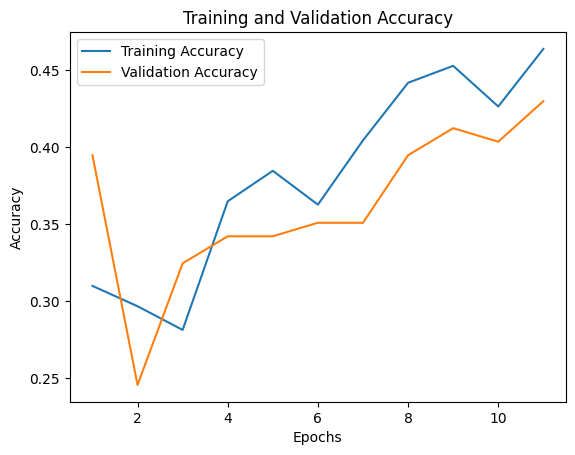

In [25]:
# Get training and validation accuracy from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show plot
plt.show()

# Performance Metrics:

In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Get true labels and predicted labels
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)
class_report = classification_report(y_val, y_val_pred_classes, target_names=categories)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)


4/4 [==============================] - 0s 88ms/step
Confusion Matrix:
[[ 0  6  6  8]
 [ 0  6 14 13]
 [ 0  8  8 11]
 [ 0  5 12 17]]

Classification Report:
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        20
       happy       0.24      0.18      0.21        33
     relaxed       0.20      0.30      0.24        27
         sad       0.35      0.50      0.41        34

    accuracy                           0.27       114
   macro avg       0.20      0.24      0.21       114
weighted avg       0.22      0.27      0.24       114



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-17-71b8dddf27e8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=true_label_counts.index, y=true_label_counts.values, palette='viridis')


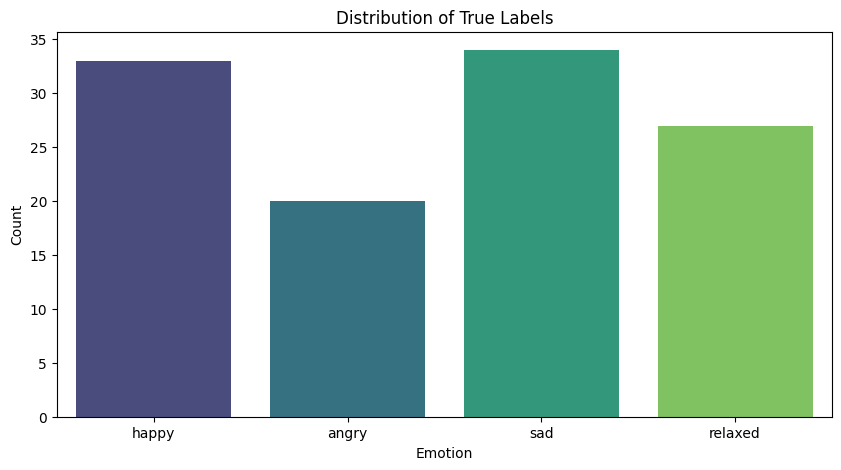

<ipython-input-17-71b8dddf27e8>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')


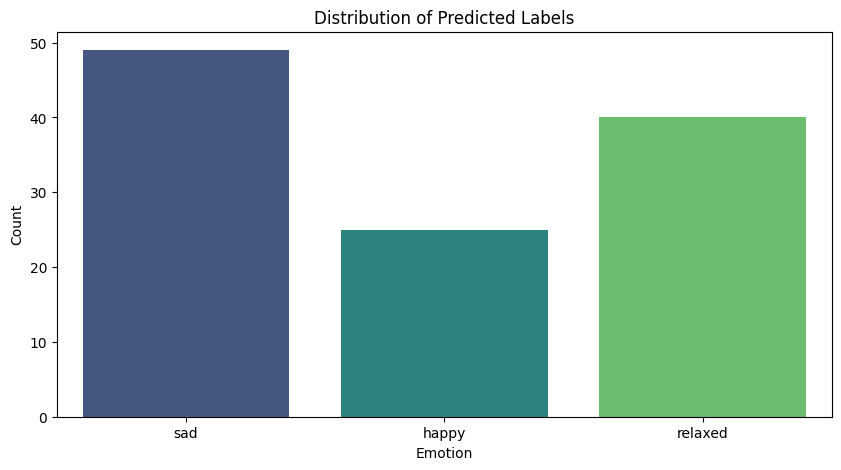

In [17]:
# Distribution of true labels
true_label_counts = pd.Series(y_val).value_counts(sort=False)
true_label_counts.index = label_encoder.inverse_transform(true_label_counts.index)

# Distribution of predicted labels
pred_label_counts = pd.Series(y_val_pred_classes).value_counts(sort=False)
pred_label_counts.index = label_encoder.inverse_transform(pred_label_counts.index)

# Plot the distribution of true labels
plt.figure(figsize=(10, 5))
sns.barplot(x=true_label_counts.index, y=true_label_counts.values, palette='viridis')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of True Labels')
plt.show()

# Plot the distribution of predicted labels
plt.figure(figsize=(10, 5))
sns.barplot(x=pred_label_counts.index, y=pred_label_counts.values, palette='viridis')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()

## ROC/AUC

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC AUC
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3])
y_pred_binarized = label_binarize(y_pred, classes=[0, 1, 2, 3])

roc_auc = roc_auc_score(y_true_binarized, y_pred_prob, multi_class='ovr')
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.5416481528980046


## Precision, Recall, F-1 Score

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Precision: 0.24475921947726462
Recall: 0.3157894736842105
F1 Score: 0.2714111314287679


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Confusion Matrix

Confusion Matrix:
[[ 0  6  6  8]
 [ 0  6 14 13]
 [ 0  8  8 11]
 [ 0  5 12 17]]


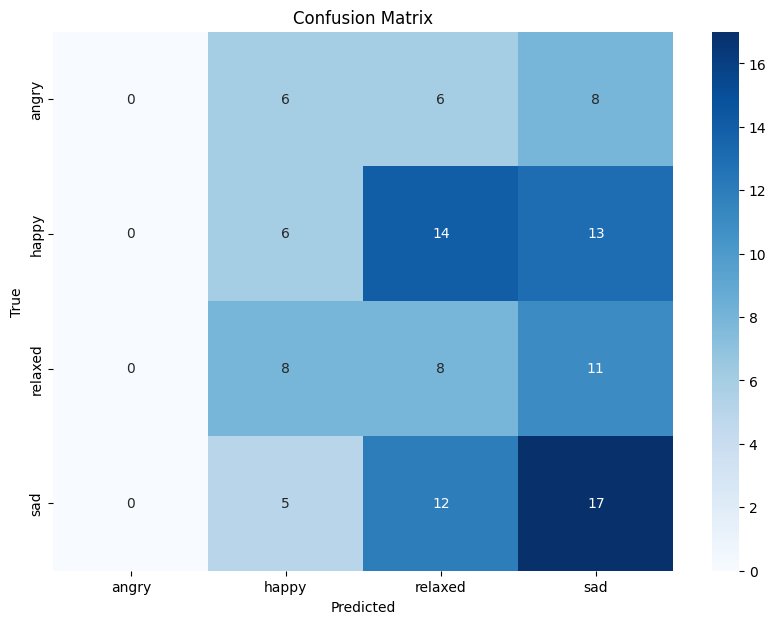

In [23]:
# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(y_val, y_val_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Accuracy

In [21]:
from sklearn.metrics import accuracy_score
# Compute accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Overall Accuracy: {accuracy}')

Overall Accuracy: 0.3157894736842105
